## K-means

all (race & ethnicity included)

In [1]:
import geopandas as gpd
from sklearn.preprocessing import robust_scale

gdf_all = gpd.read_file('data/chicago/data_all.gpkg', driver='GPKG')
len(gdf_all.columns), gdf_all.isna().sum().sum(), len(gdf_all)

cluster_variables = gdf_all.columns[1:-1]
gdf_all_scaled = robust_scale(gdf_all[cluster_variables])
cluster_variables

Index(['ag1', 'ag2', 'ag3', 'ag4', 'ag5', 'less_high_school', 'high_school',
       'college', 'bachelor_higher', 'below_45000', '45000_to_100000',
       'above_100000', 'married_couple_family', 'family_other', 'nonfamily',
       'same_house', 'moved_same_county', 'moved_same_state',
       'moved_same_country', 'moved_from_abroad', 'car', 'pub_trans',
       'means_other', 'one_or_less', 'more_than_one', 'mgt', 'svc', 'sls',
       'con', 'prod', 'below_pov', 'above_pov', 'white', 'black', 'race_other',
       'hisp', 'nhisp', 'owner', 'renter', 'single_family', 'multi_family',
       'units_other'],
      dtype='object')

10


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


k5cls
0    211
1     41
2    158
3    204
4    183
dtype: int64

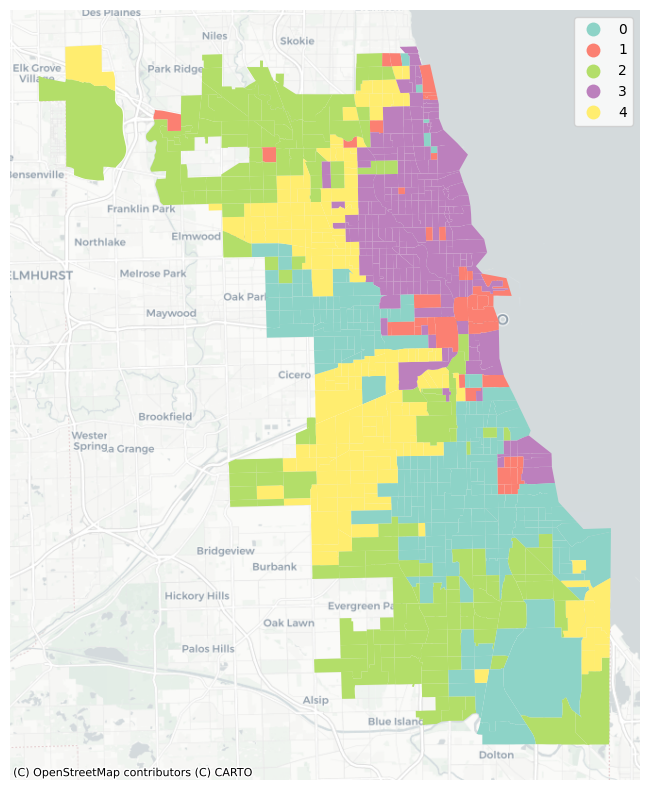

In [2]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

n_clusters = 5
n_init = 100
max_iter = 1000

imputer = SimpleImputer(strategy='mean')
gdf_all_imputed = imputer.fit_transform(gdf_all_scaled)

np.random.seed(0)
kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter)
kmeans.fit(gdf_all_imputed)
print(kmeans.n_iter_)

gdf_all['k5cls'] = kmeans.labels_
gdf_all[['GEOID_Data', 'k5cls', 'geometry']].to_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')


gdf_all = gdf_all.to_crs(3857)
# label_mapping = {0: 'Resilient Black Communities', 1: 'Diverse, Well-Educated Mobile Professionals', 
#                  2: 'Stable Middle-Aged Suburban Dwellers', 3: 'Urban White, Educated Youth',
#                  4: 'Hispanic Families in Traditional Settings'}
# gdf_all['k5cls'] = gdf_all['k5cls'].map(label_mapping)


fig, ax = plt.subplots(figsize=(10, 10))
ax = gdf_all.plot(column='k5cls', categorical=True, cmap='Set3', linewidth=0, legend=True, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1)) 
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.savefig('chicago_5cls.eps', format='eps', dpi=600, bbox_inches='tight')

gdf_all.groupby('k5cls').size()

In [41]:
import pandas as pd

k10desc = gdf_all.groupby('k5cls')[cluster_variables].describe()
master_df = pd.DataFrame()

for idx, cluster in enumerate(k10desc.T):
    df = k10desc.T[cluster].unstack()
    df['var'] = df.index
    df['cluster'] = cluster
    master_df = pd.concat([master_df, df], ignore_index=True)
    
master_df.to_csv('data/chicago/kmeans/kmeans_all_1.csv', index=False)
master_df

,count,mean,std,min,25%,50%,75%,max,var,cluster
0,211.0,0.241533,0.074894,0.028970,0.195383,0.241360,0.293851,0.468012,ag1,0
1,211.0,0.092538,0.047448,0.000000,0.061022,0.089002,0.113951,0.397800,ag2,0
2,211.0,0.272524,0.063094,0.116822,0.235459,0.276934,0.310887,0.521657,ag3,0
3,211.0,0.246357,0.059800,0.111000,0.210474,0.245247,0.281793,0.425481,ag4,0
4,211.0,0.147047,0.070852,0.024031,0.101813,0.132636,0.179335,0.491525,ag5,0
...,...,...,...,...,...,...,...,...,...,...
205,183.0,0.485740,0.169263,0.154221,0.358573,0.467929,0.592616,0.939583,owner,4
206,183.0,0.514260,0.169263,0.060417,0.407384,0.532071,0.641427,0.845779,renter,4
207,183.0,0.375447,0.226238,0.029221,0.206725,0.322270,0.527657,0.980916,single_family,4
208,183.0,0.619876,0.226673,0.019084,0.469293,0.668536,0.787523,0.958808,multi_family,4


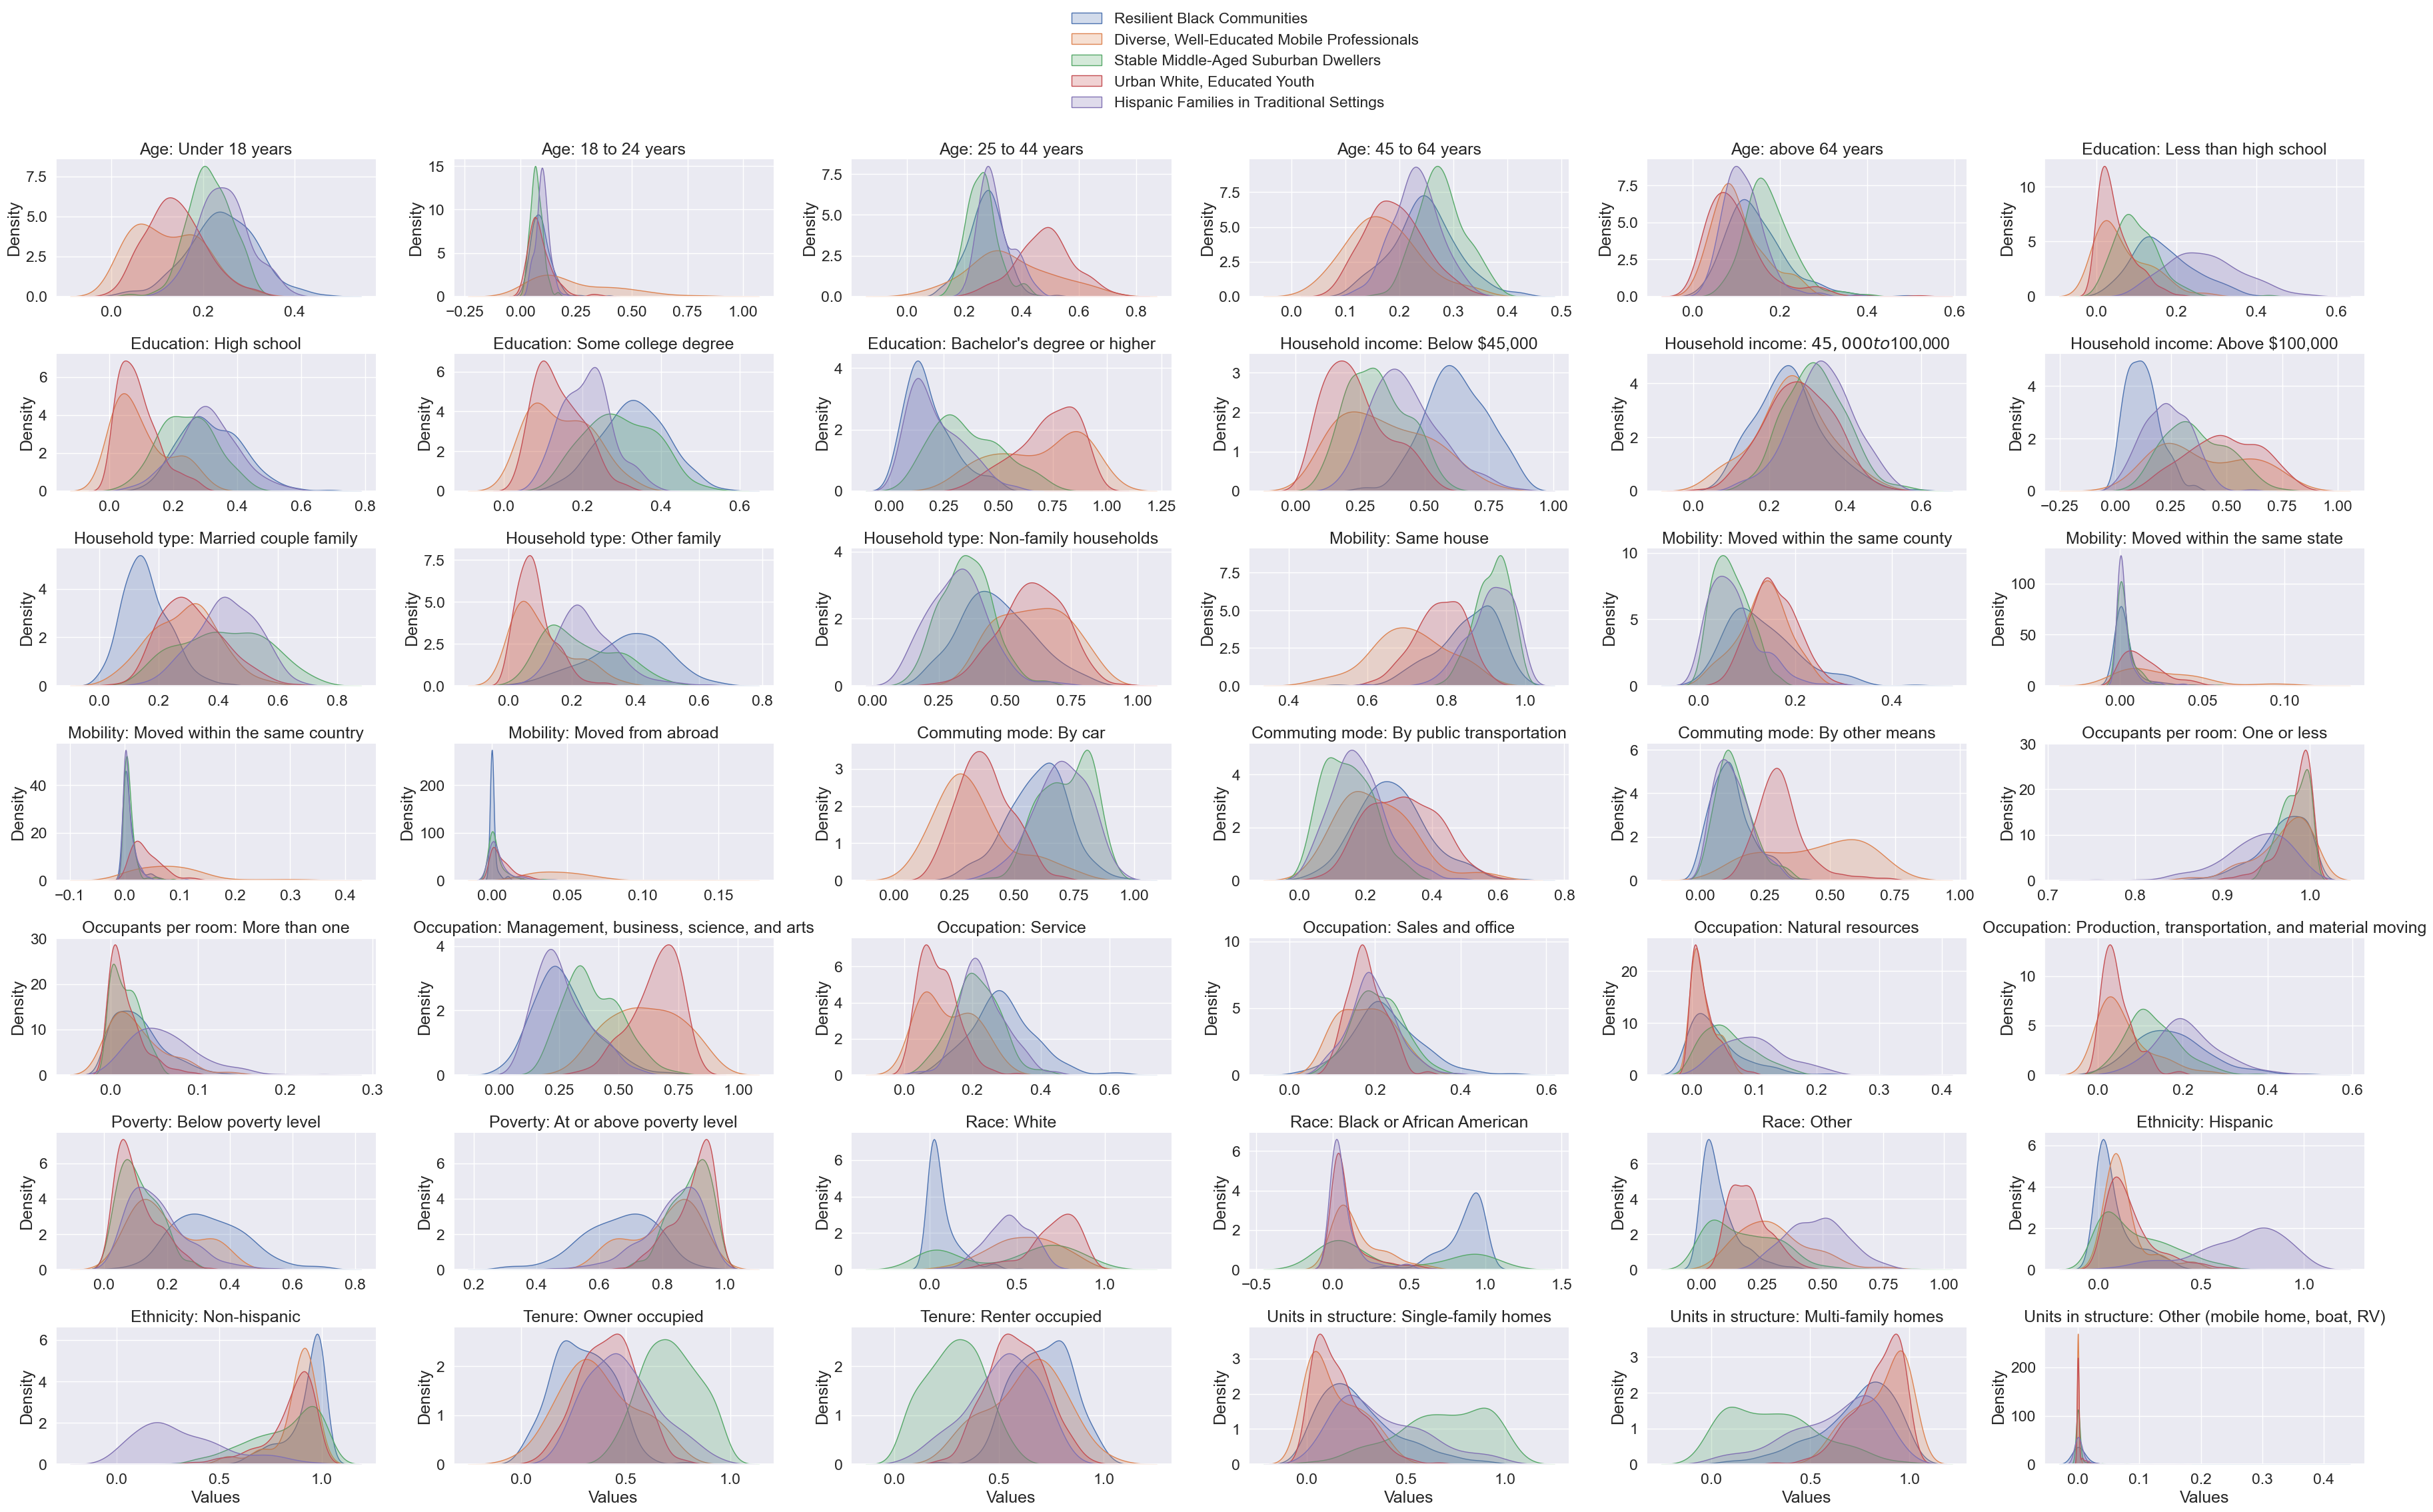

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

tidy_db = gdf_all.set_index("k5cls")
tidy_db = tidy_db[cluster_variables]
tidy_db = tidy_db.stack()
tidy_db = tidy_db.reset_index()
tidy_db = tidy_db.rename(columns={"level_1": "Attribute", 0: "Values"})

titles = ["Age: Under 18 years", "Age: 18 to 24 years", "Age: 25 to 44 years", "Age: 45 to 64 years", 
          "Age: above 64 years", "Education: Less than high school", "Education: High school",
          "Education: Some college degree", "Education: Bachelor's degree or higher", 
          "Household income: Below $45,000", "Household income: $45,000 to $100,000", "Household income: Above $100,000", 
          "Household type: Married couple family", "Household type: Other family", "Household type: Non-family households",
          "Mobility: Same house", "Mobility: Moved within the same county", "Mobility: Moved within the same state",
          "Mobility: Moved within the same country", "Mobility: Moved from abroad", "Commuting mode: By car",
          "Commuting mode: By public transportation", "Commuting mode: By other means",
          "Occupants per room: One or less", "Occupants per room: More than one", 
          "Occupation: Management, business, science, and arts", "Occupation: Service", "Occupation: Sales and office",
          "Occupation: Natural resources", "Occupation: Production, transportation, and material moving", 
          "Poverty: Below poverty level", "Poverty: At or above poverty level", "Race: White", 
          "Race: Black or African American", "Race: Other", "Ethnicity: Hispanic", "Ethnicity: Non-hispanic", 
          "Tenure: Owner occupied", "Tenure: Renter occupied", "Units in structure: Single-family homes",
          "Units in structure: Multi-family homes", "Units in structure: Other (mobile home, boat, RV)"
          ]

facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="k5cls",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=6
)

_ = facets.map(sns.kdeplot, "Values", fill=True)

for i, title in enumerate(titles):
    facets.axes[i].set_title(title)

plt.legend(loc='upper center', bbox_to_anchor=(-2.5, 10.7), frameon=False, 
           labels=['Resilient Black Communities', 'Diverse, Well-Educated Mobile Professionals', 
                   'Stable Middle-Aged Suburban Dwellers', 'Urban White, Educated Youth',
                   'Hispanic Families in Traditional Settings'])

plt.savefig('chicago_5cls_var.png', bbox_inches='tight')
plt.savefig('chicago_5cls_var.tiff', dpi=600, bbox_inches='tight')
plt.show()

evaluation

3 1.7996247746044942
5 1.59047179174021
7 1.6307820630893803
9 1.7073067634877535
11 1.6774167504047264
13 1.7486274366045529
15 1.840205251395434
17 1.920624018019003


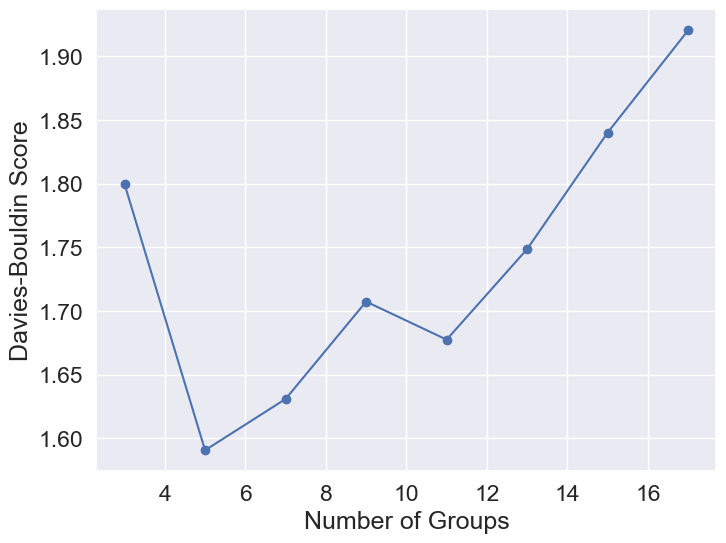

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib
# matplotlib.use('Agg') 

n_clusters = [3, 5, 7, 9, 11, 13, 15, 17]
n_init = 100
max_iter = 1000

imputer = SimpleImputer(strategy='mean')
gdf_all_imputed = imputer.fit_transform(gdf_all_scaled)

np.random.seed(0)

scores = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init=n_init, max_iter=max_iter)
    kmeans.fit(gdf_all_imputed)
    labels = kmeans.labels_
    score = davies_bouldin_score(gdf_all_imputed, labels)
    print(n, score)
    scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(n_clusters, scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Groups')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.savefig('davies_bouldin_plot.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

group 0 (black)

In [64]:
import geopandas as gpd

## white
gdf_white = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_white.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 0]

gdf_white = gdf[['GEOID_Data', 'white']]
gdf_white = gdf_white.copy()
gdf_white['age'] = None
gdf_white['education'] = gdf['white_bachelor_higher'] * gdf['white']
gdf_white['hhtype'] = gdf['white_married_couple_family'] * gdf['white']
gdf_white['mobility'] = gdf[['white_moved_same_county', 'white_moved_same_state', 'white_moved_same_country', 'white_moved_from_abroad']].sum(axis=1) * gdf['white']
gdf_white['tenure'] = gdf['white_renter'] * gdf['white']
gdf_white['units'] = gdf[['white_single_family', 'white_units_other']].sum(axis=1) * gdf['white']
gdf_white['mode'] = gdf['white_means_other'] * gdf['white']
gdf_white['poverty'] = None
gdf_white['hhinc'] = gdf['white_above_100000'] * gdf['white']
gdf_white['occupation'] = gdf['white_mgt'] * gdf['white']

education = gdf_white['education'].sum() / gdf_white['white'].sum()
hhtype = gdf_white['hhtype'].sum() / gdf_white['white'].sum()
mobility = gdf_white['mobility'].sum() / gdf_white['white'].sum()
tenure = gdf_white['tenure'].sum() / gdf_white['white'].sum()
units = gdf_white['units'].sum() / gdf_white['white'].sum()
mode = gdf_white['mode'].sum() / gdf_white['white'].sum()
hhinc = gdf_white['hhinc'].sum() / gdf_white['white'].sum()
occupation = gdf_white['occupation'].sum() / gdf_white['white'].sum()
education, hhtype, mobility, tenure, units, mode, hhinc, occupation

(0.3260190646764807,
 0.31469493284966116,
 0.2276195694688082,
 0.48909705218496935,
 0.3177883971881443,
 0.15735372693655553,
 0.22321018812676272,
 0.3539685905069104)

In [65]:
import geopandas as gpd

## black
gdf_black = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_black.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 0]

gdf_black = gdf[['GEOID_Data', 'black']]
gdf_black = gdf_black.copy()
gdf_black['age'] = None
gdf_black['education'] = gdf['black_bachelor_higher'] * gdf['black']
gdf_black['hhtype'] = gdf['black_married_couple_family'] * gdf['black']
gdf_black['mobility'] = gdf[['black_moved_same_county', 'black_moved_same_state', 'black_moved_same_country', 'black_moved_from_abroad']].sum(axis=1) * gdf['black']
gdf_black['tenure'] = gdf['black_renter'] * gdf['black']
gdf_black['units'] = gdf[['black_single_family', 'black_units_other']].sum(axis=1) * gdf['black']
gdf_black['mode'] = gdf['black_means_other'] * gdf['black']
gdf_black['poverty'] = None
gdf_black['hhinc'] = gdf['black_above_100000'] * gdf['black']
gdf_black['occupation'] = gdf['black_mgt'] * gdf['black']

education = gdf_black['education'].sum() / gdf_black['black'].sum()
hhtype = gdf_black['hhtype'].sum() / gdf_black['black'].sum()
mobility = gdf_black['mobility'].sum() / gdf_black['black'].sum()
tenure = gdf_black['tenure'].sum() / gdf_black['black'].sum()
units = gdf_black['units'].sum() / gdf_black['black'].sum()
mode = gdf_black['mode'].sum() / gdf_black['black'].sum()
hhinc = gdf_black['hhinc'].sum() / gdf_black['black'].sum()
occupation = gdf_black['occupation'].sum() / gdf_black['black'].sum()
education, hhtype, mobility, tenure, units, mode, hhinc, occupation

(0.1652105672085354,
 0.1381228427087172,
 0.1471366097000855,
 0.729385638952955,
 0.25375424951670356,
 0.10994671324949609,
 0.11289918785515989,
 0.2511474476092965)

In [66]:
import geopandas as gpd

## other
gdf_other = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_other.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 0]

gdf_other = gdf[['GEOID_Data', 'race_other']]
gdf_other = gdf_other.copy()
gdf_other['age'] = None
gdf_other['education'] = gdf['other_bachelor_higher'] * gdf['race_other']
gdf_other['hhtype'] = gdf['other_married_couple_family'] * gdf['race_other']
gdf_other['mobility'] = gdf[['other_moved_same_county', 'other_moved_same_state', 'other_moved_same_country', 'other_moved_from_abroad']].sum(axis=1) * gdf['race_other']
gdf_other['tenure'] = gdf['other_renter'] * gdf['race_other']
gdf_other['units'] = gdf[['other_single_family', 'other_units_other']].sum(axis=1) * gdf['race_other']
gdf_other['mode'] = gdf['other_means_other'] * gdf['race_other']
gdf_other['poverty'] = None
gdf_other['hhinc'] = gdf['other_above_100000'] * gdf['race_other']
gdf_other['occupation'] = gdf['other_mgt'] * gdf['race_other']

education = gdf_other['education'].sum() / gdf_other['race_other'].sum()
hhtype = gdf_other['hhtype'].sum() / gdf_other['race_other'].sum()
mobility = gdf_other['mobility'].sum() / gdf_other['race_other'].sum()
tenure = gdf_other['tenure'].sum() / gdf_other['race_other'].sum()
units = gdf_other['units'].sum() / gdf_other['race_other'].sum()
mode = gdf_other['mode'].sum() / gdf_other['race_other'].sum()
hhinc = gdf_other['hhinc'].sum() / gdf_other['race_other'].sum()
occupation = gdf_other['occupation'].sum() / gdf_other['race_other'].sum()
education, hhtype, mobility, tenure, units, mode, hhinc, occupation

(0.21675637254130917,
 0.3186713339615846,
 0.17600816348025575,
 0.5866733702253397,
 0.3431208559650708,
 0.14317606850106246,
 0.16294682529406176,
 0.2667381816818075)

In [67]:
import geopandas as gpd

## nhisp
gdf_nhisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_nhisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 0]

gdf_nhisp = gdf[['GEOID_Data', 'nhisp']]
gdf_nhisp = gdf_nhisp.copy()
gdf_nhisp['age'] = None
gdf_nhisp['education'] = gdf['nhisp_bachelor_higher'] * gdf['nhisp']
gdf_nhisp['hhtype'] = gdf['nhisp_married_couple_family'] * gdf['nhisp']
gdf_nhisp['mobility'] = gdf[['nhisp_moved_same_county', 'nhisp_moved_same_state', 'nhisp_moved_same_country', 'nhisp_moved_from_abroad']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['tenure'] = gdf['nhisp_renter'] * gdf['nhisp']
gdf_nhisp['units'] = gdf[['nhisp_single_family', 'nhisp_units_other']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['mode'] = gdf['nhisp_means_other'] * gdf['nhisp']
gdf_nhisp['poverty'] = None
gdf_nhisp['hhinc'] = gdf['nhisp_above_100000'] * gdf['nhisp']
gdf_nhisp['occupation'] = gdf['nhisp_mgt'] * gdf['nhisp']

education = gdf_nhisp['education'].sum() / gdf_nhisp['nhisp'].sum()
hhtype = gdf_nhisp['hhtype'].sum() / gdf_nhisp['nhisp'].sum()
mobility = gdf_nhisp['mobility'].sum() / gdf_nhisp['nhisp'].sum()
tenure = gdf_nhisp['tenure'].sum() / gdf_nhisp['nhisp'].sum()
units = gdf_nhisp['units'].sum() / gdf_nhisp['nhisp'].sum()
mode = gdf_nhisp['mode'].sum() / gdf_nhisp['nhisp'].sum()
hhinc = gdf_nhisp['hhinc'].sum() / gdf_nhisp['nhisp'].sum()
occupation = gdf_nhisp['occupation'].sum() / gdf_nhisp['nhisp'].sum()
education, hhtype, mobility, tenure, units, mode, hhinc, occupation

(0.18760653585054576,
 0.1439514753082997,
 0.15284039520551843,
 0.7188541608678577,
 0.25290768922927426,
 0.11860550894774344,
 0.12162212936926017,
 0.2705198841513733)

In [68]:
import geopandas as gpd

## hisp
gdf_hisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_hisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 0]

gdf_hisp = gdf[['GEOID_Data', 'hisp']]
gdf_hisp = gdf_hisp.copy()
gdf_hisp['age'] = None
gdf_hisp['education'] = gdf['hisp_bachelor_higher'] * gdf['hisp']
gdf_hisp['hhtype'] = gdf['hisp_married_couple_family'] * gdf['hisp']
gdf_hisp['mobility'] = gdf[['hisp_moved_same_county', 'hisp_moved_same_state', 'hisp_moved_same_country', 'hisp_moved_from_abroad']].sum(axis=1) * gdf['hisp']
gdf_hisp['tenure'] = gdf['hisp_renter'] * gdf['hisp']
gdf_hisp['units'] = gdf[['hisp_single_family', 'hisp_units_other']].sum(axis=1) * gdf['hisp']
gdf_hisp['mode'] = gdf['hisp_means_other'] * gdf['hisp']
gdf_hisp['poverty'] = None
gdf_hisp['hhinc'] = gdf['hisp_above_100000'] * gdf['hisp']
gdf_hisp['occupation'] = gdf['hisp_mgt'] * gdf['hisp']

education = gdf_hisp['education'].sum() / gdf_hisp['hisp'].sum()
hhtype = gdf_hisp['hhtype'].sum() / gdf_hisp['hisp'].sum()
mobility = gdf_hisp['mobility'].sum() / gdf_hisp['hisp'].sum()
tenure = gdf_hisp['tenure'].sum() / gdf_hisp['hisp'].sum()
units = gdf_hisp['units'].sum() / gdf_hisp['hisp'].sum()
mode = gdf_hisp['mode'].sum() / gdf_hisp['hisp'].sum()
hhinc = gdf_hisp['hhinc'].sum() / gdf_hisp['hisp'].sum()
occupation = gdf_hisp['occupation'].sum() / gdf_hisp['hisp'].sum()
education, hhtype, mobility, tenure, units, mode, hhinc, occupation

(0.11230099193123912,
 0.3487713167050194,
 0.18305997114024603,
 0.5479338776024107,
 0.3827919148090393,
 0.10804968777393306,
 0.138475187720095,
 0.1787972529618741)

group 3 (white)

In [19]:
import geopandas as gpd

## white
gdf_white = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_white.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 3]

gdf_white = gdf[['GEOID_Data', 'white']]
gdf_white = gdf_white.copy()
gdf_white['age'] = gdf[['white_ag2', 'white_ag5']].sum(axis=1) * gdf['white']
gdf_white['education'] = gdf[['white_less_high_school', 'white_high_school', 'white_college']].sum(axis=1) * gdf['white']
gdf_white['hhtype'] = gdf[['white_married_couple_family', 'white_family_other']].sum(axis=1) * gdf['white']
gdf_white['mobility'] = gdf[['white_moved_same_state', 'white_moved_same_country', 'white_moved_from_abroad']].sum(axis=1) * gdf['white']
gdf_white['tenure'] = None
gdf_white['units'] = gdf[['white_single_family', 'white_units_other']].sum(axis=1) * gdf['white']
gdf_white['mode'] = gdf[['white_car', 'white_means_other']].sum(axis=1) * gdf['hisp']
gdf_white['poverty'] = gdf['white_below_pov'] * gdf['white']
gdf_white['hhinc'] = gdf['white_below_45000'] * gdf['white']
gdf_white['occupation'] = gdf[['white_svc', 'white_sls', 'white_con', 'white_prod']].sum(axis=1) * gdf['white']

age = gdf_white['age'].sum() / gdf_white['white'].sum()
education = gdf_white['education'].sum() / gdf_white['white'].sum()
hhtype = gdf_white['hhtype'].sum() / gdf_white['white'].sum()
mobility = gdf_white['mobility'].sum() / gdf_white['white'].sum()
units = gdf_white['units'].sum() / gdf_white['white'].sum()
mode = gdf_white['mode'].sum() / gdf_white['white'].sum()
poverty = gdf_white['poverty'].sum() / gdf_white['white'].sum()
hhinc = gdf_white['hhinc'].sum() / gdf_white['white'].sum()
occupation = gdf_white['occupation'].sum() / gdf_white['white'].sum()
age, education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.1856136543377903,
 0.2139511223287948,
 0.38115962917625956,
 0.06468556720857319,
 0.15176177302442304,
 0.14479123603407695,
 0.07859541186358335,
 0.18617150661456228,
 0.31674414898342784)

In [85]:
import geopandas as gpd

## black
gdf_black = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_black.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 3]

gdf_black = gdf[['GEOID_Data', 'black']]
gdf_black = gdf_black.copy()
gdf_black['age'] = gdf[['black_ag2', 'black_ag5']].sum(axis=1) * gdf['black']
gdf_black['education'] = gdf[['black_less_high_school', 'black_high_school', 'black_college']].sum(axis=1) * gdf['black']
gdf_black['hhtype'] = gdf[['black_married_couple_family', 'black_family_other']].sum(axis=1) * gdf['black']
gdf_black['mobility'] = gdf[['black_moved_same_state', 'black_moved_same_country', 'black_moved_from_abroad']].sum(axis=1) * gdf['black']
gdf_black['tenure'] = None
gdf_black['units'] = gdf[['black_single_family', 'black_units_other']].sum(axis=1) * gdf['black']
gdf_black['mode'] = gdf[['black_car', 'black_means_other']].sum(axis=1) * gdf['hisp']
gdf_black['poverty'] = gdf['black_below_pov'] * gdf['black']
gdf_black['hhinc'] = gdf['black_below_45000'] * gdf['black']
gdf_black['occupation'] = gdf[['black_svc', 'black_sls', 'black_con', 'black_prod']].sum(axis=1) * gdf['black']

age = gdf_black['age'].sum() / gdf_black['black'].sum()
education = gdf_black['education'].sum() / gdf_black['black'].sum()
hhtype = gdf_black['hhtype'].sum() / gdf_black['black'].sum()
mobility = gdf_black['mobility'].sum() / gdf_black['black'].sum()
units = gdf_black['units'].sum() / gdf_black['black'].sum()
mode = gdf_black['mode'].sum() / gdf_black['black'].sum()
poverty = gdf_black['poverty'].sum() / gdf_black['black'].sum()
hhinc = gdf_black['hhinc'].sum() / gdf_black['black'].sum()
occupation = gdf_black['occupation'].sum() / gdf_black['black'].sum()
age, education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.23404034718724998,
 0.5507330818521113,
 0.3528849154306787,
 0.04352937590739323,
 0.0798148850334279,
 0.9019877136226113,
 0.10520062062180582,
 0.49387604861660234,
 0.5157494821834503)

In [72]:
import geopandas as gpd

## other
gdf_other = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_other.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 3]

gdf_other = gdf[['GEOID_Data', 'race_other']]
gdf_other = gdf_other.copy()
gdf_other['age'] = gdf[['other_ag2', 'other_ag5']].sum(axis=1) * gdf['race_other']
gdf_other['education'] = gdf[['other_less_high_school', 'other_high_school', 'other_college']].sum(axis=1) * gdf['race_other']
gdf_other['hhtype'] = gdf[['other_married_couple_family', 'other_family_other']].sum(axis=1) * gdf['race_other']
gdf_other['mobility'] = gdf[['other_moved_same_state', 'other_moved_same_country', 'other_moved_from_abroad']].sum(axis=1) * gdf['race_other']
gdf_other['tenure'] = None
gdf_other['units'] = gdf[['other_single_family', 'other_units_other']].sum(axis=1) * gdf['race_other']
gdf_other['mode'] = gdf[['other_car', 'other_means_other']].sum(axis=1) * gdf['hisp']
gdf_other['poverty'] = gdf['other_below_pov'] * gdf['race_other']
gdf_other['hhinc'] = gdf['other_below_45000'] * gdf['race_other']
gdf_other['occupation'] = gdf[['other_svc', 'other_sls', 'other_con', 'other_prod']].sum(axis=1) * gdf['race_other']

age = gdf_other['age'].sum() / gdf_other['race_other'].sum()
education = gdf_other['education'].sum() / gdf_other['race_other'].sum()
hhtype = gdf_other['hhtype'].sum() / gdf_other['race_other'].sum()
mobility = gdf_other['mobility'].sum() / gdf_other['race_other'].sum()
units = gdf_other['units'].sum() / gdf_other['race_other'].sum()
mode = gdf_other['mode'].sum() / gdf_other['race_other'].sum()
poverty = gdf_other['poverty'].sum() / gdf_other['race_other'].sum()
hhinc = gdf_other['hhinc'].sum() / gdf_other['race_other'].sum()
occupation = gdf_other['occupation'].sum() / gdf_other['race_other'].sum()
age, education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.18443425653227322,
 0.35228111486262453,
 0.44014797923635535,
 0.06996395253512924,
 0.13861750052725505,
 0.53127804060161,
 0.126124052799802,
 0.2677964630747165,
 0.35503436401487015)

In [32]:
import geopandas as gpd

## nhisp
gdf_nhisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_nhisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 3]

gdf_nhisp = gdf[['GEOID_Data', 'nhisp']]
gdf_nhisp = gdf_nhisp.copy()
gdf_nhisp['age'] = gdf[['nhisp_ag1', 'nhisp_ag5']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['education'] = gdf[['nhisp_less_high_school', 'nhisp_high_school', 'nhisp_college']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['hhtype'] = gdf[['nhisp_married_couple_family', 'nhisp_family_other']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['mobility'] = gdf[['nhisp_moved_same_county', 'nhisp_moved_same_state', 'nhisp_moved_same_country', 'nhisp_moved_from_abroad']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['tenure'] = gdf['nhisp_owner'] * gdf['nhisp']
gdf_nhisp['units'] = gdf[['nhisp_single_family', 'nhisp_units_other']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['mode'] = None
gdf_nhisp['poverty'] = gdf['nhisp_below_pov'] * gdf['nhisp']
gdf_nhisp['hhinc'] = gdf['nhisp_below_45000'] * gdf['nhisp']
gdf_nhisp['occupation'] = gdf[['nhisp_svc', 'nhisp_sls', 'nhisp_con', 'nhisp_prod']].sum(axis=1) * gdf['nhisp']

age = gdf_nhisp['age'].sum() / gdf_nhisp['nhisp'].sum()
education = gdf_nhisp['education'].sum() / gdf_nhisp['nhisp'].sum()
hhtype = gdf_nhisp['hhtype'].sum() / gdf_nhisp['nhisp'].sum()
mobility = gdf_nhisp['mobility'].sum() / gdf_nhisp['nhisp'].sum()
tenure = gdf_nhisp['tenure'].sum() / gdf['nhisp'].sum()
units = gdf_nhisp['units'].sum() / gdf_nhisp['nhisp'].sum()
poverty = gdf_nhisp['poverty'].sum() / gdf_nhisp['nhisp'].sum()
hhinc = gdf_nhisp['hhinc'].sum() / gdf_nhisp['nhisp'].sum()
occupation = gdf_nhisp['occupation'].sum() / gdf_nhisp['nhisp'].sum()
age, education, hhtype, mobility, tenure, units, poverty, hhinc, occupation

(0.20135739975464637,
 0.17587488832958473,
 0.2976372540968405,
 0.2806202980246023,
 0.34539825621693243,
 0.07572944995597425,
 0.11942912505216423,
 0.23283770643001866,
 0.2822737806175386)

In [74]:
import geopandas as gpd

## hisp
gdf_hisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_hisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 3]

gdf_hisp = gdf[['GEOID_Data', 'hisp']]
gdf_hisp = gdf_hisp.copy()
gdf_hisp['age'] = gdf[['hisp_ag2', 'hisp_ag5']].sum(axis=1) * gdf['hisp']
gdf_hisp['education'] = gdf[['hisp_less_high_school', 'hisp_high_school', 'hisp_college']].sum(axis=1) * gdf['hisp']
gdf_hisp['hhtype'] = gdf[['hisp_married_couple_family', 'hisp_family_other']].sum(axis=1) * gdf['hisp']
gdf_hisp['mobility'] = gdf[['hisp_moved_same_state', 'hisp_moved_same_country', 'hisp_moved_from_abroad']].sum(axis=1) * gdf['hisp']
gdf_hisp['tenure'] = None
gdf_hisp['units'] = gdf[['hisp_single_family', 'hisp_units_other']].sum(axis=1) * gdf['hisp']
gdf_hisp['mode'] = gdf[['hisp_car', 'hisp_means_other']].sum(axis=1) * gdf['hisp']
gdf_hisp['poverty'] = gdf['hisp_below_pov'] * gdf['hisp']
gdf_hisp['hhinc'] = gdf['hisp_below_45000'] * gdf['hisp']
gdf_hisp['occupation'] = gdf[['hisp_svc', 'hisp_sls', 'hisp_con', 'hisp_prod']].sum(axis=1) * gdf['hisp']

age = gdf_hisp['age'].sum() / gdf_hisp['hisp'].sum()
education = gdf_hisp['education'].sum() / gdf_hisp['hisp'].sum()
hhtype = gdf_hisp['hhtype'].sum() / gdf_hisp['hisp'].sum()
mobility = gdf_hisp['mobility'].sum() / gdf_hisp['hisp'].sum()
units = gdf_hisp['units'].sum() / gdf_hisp['hisp'].sum()
mode = gdf_hisp['mode'].sum() / gdf_hisp['hisp'].sum()
poverty = gdf_hisp['poverty'].sum() / gdf_hisp['hisp'].sum()
hhinc = gdf_hisp['hhinc'].sum() / gdf_hisp['hisp'].sum()
occupation = gdf_hisp['occupation'].sum() / gdf_hisp['hisp'].sum()
age, education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.20097228685432522,
 0.6120257841254315,
 0.48813293449392386,
 0.04505148789382583,
 0.1264930660297275,
 0.7093090876678252,
 0.1564789074776142,
 0.35732646843746035,
 0.5810400008833912)

group 4 (hisp)

In [78]:
import geopandas as gpd

## white
gdf_white = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_white.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 4]

gdf_white = gdf[['GEOID_Data', 'white']]
gdf_white = gdf_white.copy()
gdf_white['age'] = None
gdf_white['education'] = gdf['white_bachelor_higher'] * gdf['white']
gdf_white['hhtype'] = gdf['white_nonfamily'] * gdf['white']
gdf_white['mobility'] = gdf[['white_moved_same_county', 'white_moved_same_state', 'white_moved_same_country', 'white_moved_from_abroad']].sum(axis=1) * gdf['white']
gdf_white['tenure'] = None
gdf_white['units'] = gdf[['white_single_family', 'white_units_other']].sum(axis=1) * gdf['white']
gdf_white['mode'] = gdf['white_means_other'] * gdf['hisp']
gdf_white['poverty'] = gdf['white_below_pov'] * gdf['white']
gdf_white['hhinc'] = gdf['white_above_100000'] * gdf['white']
gdf_white['occupation'] = gdf['white_mgt'] * gdf['white']

education = gdf_white['education'].sum() / gdf_white['white'].sum()
hhtype = gdf_white['hhtype'].sum() / gdf_white['white'].sum()
mobility = gdf_white['mobility'].sum() / gdf_white['white'].sum()
units = gdf_white['units'].sum() / gdf_white['white'].sum()
mode = gdf_white['mode'].sum() / gdf_white['white'].sum()
poverty = gdf_white['poverty'].sum() / gdf_white['white'].sum()
hhinc = gdf_white['hhinc'].sum() / gdf_white['white'].sum()
occupation = gdf_white['occupation'].sum() / gdf_white['white'].sum()
education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.2467609121006334,
 0.3470736021573732,
 0.09023291990665327,
 0.417487951114153,
 0.17963043106599064,
 0.14327170238622786,
 0.2608839863004923,
 0.29291257902535217)

In [86]:
import geopandas as gpd

## black
gdf_black = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_black.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 4]

gdf_black = gdf[['GEOID_Data', 'black']]
gdf_black = gdf_black.copy()
gdf_black['age'] = None
gdf_black['education'] = gdf['black_bachelor_higher'] * gdf['black']
gdf_black['hhtype'] = gdf['black_nonfamily'] * gdf['black']
gdf_black['mobility'] = gdf[['black_moved_same_county', 'black_moved_same_state', 'black_moved_same_country', 'black_moved_from_abroad']].sum(axis=1) * gdf['black']
gdf_black['tenure'] = None
gdf_black['units'] = gdf[['black_single_family', 'black_units_other']].sum(axis=1) * gdf['black']
gdf_black['mode'] = gdf['black_means_other'] * gdf['black']
gdf_black['poverty'] = gdf['black_below_pov'] * gdf['black']
gdf_black['hhinc'] = gdf['black_above_100000'] * gdf['black']
gdf_black['occupation'] = gdf['black_mgt'] * gdf['black']

education = gdf_black['education'].sum() / gdf_black['black'].sum()
hhtype = gdf_black['hhtype'].sum() / gdf_black['black'].sum()
mobility = gdf_black['mobility'].sum() / gdf_black['black'].sum()
units = gdf_black['units'].sum() / gdf_black['black'].sum()
mode = gdf_black['mode'].sum() / gdf_black['black'].sum()
poverty = gdf_black['poverty'].sum() / gdf_black['black'].sum()
hhinc = gdf_black['hhinc'].sum() / gdf_black['black'].sum()
occupation = gdf_black['occupation'].sum() / gdf_black['black'].sum()
education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.20747039480097032,
 0.39022842091146315,
 0.13792394386004134,
 0.28044751069849216,
 0.1315646163102546,
 0.17342174871506633,
 0.15608423446742486,
 0.29153625462593685)

In [81]:
import geopandas as gpd

## other
gdf_other = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_other.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 4]

gdf_other = gdf[['GEOID_Data', 'race_other']]
gdf_other = gdf_other.copy()
gdf_other['age'] = None
gdf_other['education'] = gdf['other_bachelor_higher'] * gdf['race_other']
gdf_other['hhtype'] = gdf['other_nonfamily'] * gdf['race_other']
gdf_other['mobility'] = gdf[['other_moved_same_county', 'other_moved_same_state', 'other_moved_same_country', 'other_moved_from_abroad']].sum(axis=1) * gdf['race_other']
gdf_other['tenure'] = None
gdf_other['units'] = gdf[['other_single_family', 'other_units_other']].sum(axis=1) * gdf['race_other']
gdf_other['mode'] = gdf['other_means_other'] * gdf['hisp']
gdf_other['poverty'] = gdf['other_below_pov'] * gdf['race_other']
gdf_other['hhinc'] = gdf['other_above_100000'] * gdf['race_other']
gdf_other['occupation'] = gdf['other_mgt'] * gdf['race_other']

education = gdf_other['education'].sum() / gdf_other['race_other'].sum()
hhtype = gdf_other['hhtype'].sum() / gdf_other['race_other'].sum()
mobility = gdf_other['mobility'].sum() / gdf_other['race_other'].sum()
units = gdf_other['units'].sum() / gdf_other['race_other'].sum()
mode = gdf_other['mode'].sum() / gdf_other['race_other'].sum()
poverty = gdf_other['poverty'].sum() / gdf_other['race_other'].sum()
hhinc = gdf_other['hhinc'].sum() / gdf_other['race_other'].sum()
occupation = gdf_other['occupation'].sum() / gdf_other['race_other'].sum()
education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.17404198966702353,
 0.22614408176295575,
 0.07229305174060946,
 0.39518329814414405,
 0.15506536081040648,
 0.2727586902924117,
 0.2274421283506453,
 0.21388999924373814)

In [82]:
import geopandas as gpd

## nhisp
gdf_nhisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_nhisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 4]

gdf_nhisp = gdf[['GEOID_Data', 'nhisp']]
gdf_nhisp = gdf_nhisp.copy()
gdf_nhisp['age'] = None
gdf_nhisp['education'] = gdf['nhisp_bachelor_higher'] * gdf['nhisp']
gdf_nhisp['hhtype'] = gdf['nhisp_nonfamily'] * gdf['nhisp']
gdf_nhisp['mobility'] = gdf[['nhisp_moved_same_county', 'nhisp_moved_same_state', 'nhisp_moved_same_country', 'nhisp_moved_from_abroad']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['tenure'] = None
gdf_nhisp['units'] = gdf[['nhisp_single_family', 'nhisp_units_other']].sum(axis=1) * gdf['nhisp']
gdf_nhisp['mode'] = gdf['nhisp_means_other'] * gdf['hisp']
gdf_nhisp['poverty'] = gdf['nhisp_below_pov'] * gdf['nhisp']
gdf_nhisp['hhinc'] = gdf['nhisp_above_100000'] * gdf['nhisp']
gdf_nhisp['occupation'] = gdf['nhisp_mgt'] * gdf['nhisp']

education = gdf_nhisp['education'].sum() / gdf_nhisp['nhisp'].sum()
hhtype = gdf_nhisp['hhtype'].sum() / gdf_nhisp['nhisp'].sum()
mobility = gdf_nhisp['mobility'].sum() / gdf_nhisp['nhisp'].sum()
units = gdf_nhisp['units'].sum() / gdf_nhisp['nhisp'].sum()
mode = gdf_nhisp['mode'].sum() / gdf_nhisp['nhisp'].sum()
poverty = gdf_nhisp['poverty'].sum() / gdf_nhisp['nhisp'].sum()
hhinc = gdf_nhisp['hhinc'].sum() / gdf_nhisp['nhisp'].sum()
occupation = gdf_nhisp['occupation'].sum() / gdf_nhisp['nhisp'].sum()
education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.38718608701938995,
 0.43147574683824697,
 0.12924131623468293,
 0.36588265434019096,
 0.33269161335071723,
 0.16937153802033322,
 0.28407105970998897,
 0.41339773269341684)

In [83]:
import geopandas as gpd

## hisp
gdf_hisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_hisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop, on='GEOID_Data', how='left')
gdf = gdf[gdf['k5cls'] == 4]

gdf_hisp = gdf[['GEOID_Data', 'hisp']]
gdf_hisp = gdf_hisp.copy()
gdf_hisp['age'] = None
gdf_hisp['education'] = gdf['hisp_bachelor_higher'] * gdf['hisp']
gdf_hisp['hhtype'] = gdf['hisp_nonfamily'] * gdf['hisp']
gdf_hisp['mobility'] = gdf[['hisp_moved_same_county', 'hisp_moved_same_state', 'hisp_moved_same_country', 'hisp_moved_from_abroad']].sum(axis=1) * gdf['hisp']
gdf_hisp['tenure'] = None
gdf_hisp['units'] = gdf[['hisp_single_family', 'hisp_units_other']].sum(axis=1) * gdf['hisp']
gdf_hisp['mode'] = gdf['hisp_means_other'] * gdf['hisp']
gdf_hisp['poverty'] = gdf['hisp_below_pov'] * gdf['hisp']
gdf_hisp['hhinc'] = gdf['hisp_above_100000'] * gdf['hisp']
gdf_hisp['occupation'] = gdf['hisp_mgt'] * gdf['hisp']

education = gdf_hisp['education'].sum() / gdf_hisp['hisp'].sum()
hhtype = gdf_hisp['hhtype'].sum() / gdf_hisp['hisp'].sum()
mobility = gdf_hisp['mobility'].sum() / gdf_hisp['hisp'].sum()
units = gdf_hisp['units'].sum() / gdf_hisp['hisp'].sum()
mode = gdf_hisp['mode'].sum() / gdf_hisp['hisp'].sum()
poverty = gdf_hisp['poverty'].sum() / gdf_hisp['hisp'].sum()
hhinc = gdf_hisp['hhinc'].sum() / gdf_hisp['hisp'].sum()
occupation = gdf_hisp['occupation'].sum() / gdf_hisp['hisp'].sum()
education, hhtype, mobility, units, mode, poverty, hhinc, occupation

(0.1147900719098876,
 0.21928416477049545,
 0.06475370817643017,
 0.4044089245899442,
 0.09824943106417958,
 0.16828282320891094,
 0.21012114576417207,
 0.18029754241598056)

equal opportunity

In [1]:
import geopandas as gpd
import numpy as np

## white
gdf = gpd.read_file('data/chicago/data_white.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop[['GEOID_Data', 'total', 'white', 'black', 'race_other', 'hisp', 'nhisp']], on='GEOID_Data', how='left')

white_columns = {
    0: ['white_less_high_school', 'white_high_school', 'white_college', 'white_family_other',
        'white_nonfamily', 'white_same_house', 'white_owner', 'white_multi_family', 'white_car',
        'white_pub_trans', 'white_below_45000', 'white_45000_to_100000', 'white_svc', 'white_sls',
        'white_con', 'white_prod'],
    1: ['white_college','white_bachelor_higher', 'white_married_couple_family', 'white_nonfamily',
        'white_same_house', 'white_moved_same_county', 'white_multi_family', 'white_pub_trans', 
        'white_means_other', 'white_above_pov', 'white_mgt', 'white_svc', 'white_sls'],
    2: ['white_ag3', 'white_ag4', 'white_ag5', 'white_same_house', 'white_owner', 'white_single_family', 
        'white_car', 'white_above_pov', 'white_45000_to_100000', 'white_above_100000'],
    3: ['white_ag1', 'white_ag3', 'white_ag4', 'white_bachelor_higher', 'white_nonfamily',
        'white_same_house', 'white_moved_same_county', 'white_multi_family', 'white_pub_trans',
        'white_above_pov', 'white_45000_to_100000', 'white_above_100000', 'white_mgt'],
    4: ['white_less_high_school', 'white_high_school', 'white_college', 'white_married_couple_family',
        'white_family_other', 'white_same_house', 'white_multi_family', 'white_car', 'white_pub_trans',
        'white_above_pov', 'white_below_45000', 'white_45000_to_100000', 'white_svc', 'white_sls',
        'white_con', 'white_prod']
}
cnt = [8, 7, 7, 9, 9]
gdf['dp_white'], i = np.nan, 0
for k5cls, columns in white_columns.items():
    condition = gdf['k5cls'] == k5cls
    gdf.loc[condition, 'dp_white'] = gdf.loc[condition, columns].sum(axis=1) / cnt[i]
    i = i + 1

gdf_all = gdf[['GEOID_Data', 'dp_white', 'geometry']]

In [2]:
import geopandas as gpd
import numpy as np

## black
gdf = gpd.read_file('data/chicago/data_black.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop[['GEOID_Data', 'total', 'black']], on='GEOID_Data', how='left')

black_columns = {
    0: ['black_less_high_school', 'black_high_school', 'black_college', 'black_family_other',
        'black_nonfamily', 'black_same_house', 'black_owner', 'black_multi_family', 'black_car',
        'black_pub_trans', 'black_below_45000', 'black_45000_to_100000', 'black_svc', 'black_sls',
        'black_con', 'black_prod'],
    1: ['black_college','black_bachelor_higher', 'black_married_couple_family', 'black_nonfamily',
        'black_same_house', 'black_moved_same_county', 'black_multi_family', 'black_pub_trans', 
        'black_means_other', 'black_above_pov', 'black_mgt', 'black_svc', 'black_sls'],
    2: ['black_ag3', 'black_ag4', 'black_ag5', 'black_same_house', 'black_owner', 'black_single_family', 
        'black_car', 'black_above_pov', 'black_45000_to_100000', 'black_above_100000'],
    3: ['black_ag1', 'black_ag3', 'black_ag4', 'black_bachelor_higher', 'black_nonfamily',
        'black_same_house', 'black_moved_same_county', 'black_multi_family', 'black_pub_trans',
        'black_above_pov', 'black_45000_to_100000', 'black_above_100000', 'black_mgt'],
    4: ['black_less_high_school', 'black_high_school', 'black_college', 'black_married_couple_family',
        'black_family_other', 'black_same_house', 'black_multi_family', 'black_car', 'black_pub_trans',
        'black_above_pov', 'black_below_45000', 'black_45000_to_100000', 'black_svc', 'black_sls',
        'black_con', 'black_prod']
}
cnt = [8, 7, 7, 9, 9]
gdf['dp_black'], i = np.nan, 0
for k5cls, columns in black_columns.items():
    condition = gdf['k5cls'] == k5cls
    gdf.loc[condition, 'dp_black'] = gdf.loc[condition, columns].sum(axis=1) / cnt[i]
    i = i + 1

gdf_all = gdf_all.merge(gdf[['GEOID_Data', 'dp_black']], on='GEOID_Data', how='left')

In [3]:
import geopandas as gpd
import numpy as np

## other
gdf_other = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_other.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop[['GEOID_Data', 'total', 'race_other']], on='GEOID_Data', how='left')

other_columns = {
    0: ['other_less_high_school', 'other_high_school', 'other_college', 'other_family_other',
        'other_nonfamily', 'other_same_house', 'other_owner', 'other_multi_family', 'other_car',
        'other_pub_trans', 'other_below_45000', 'other_45000_to_100000', 'other_svc', 'other_sls',
        'other_con', 'other_prod'],
    1: ['other_college','other_bachelor_higher', 'other_married_couple_family', 'other_nonfamily',
        'other_same_house', 'other_moved_same_county', 'other_multi_family', 'other_pub_trans', 
        'other_means_other', 'other_above_pov', 'other_mgt', 'other_svc', 'other_sls'],
    2: ['other_ag3', 'other_ag4', 'other_ag5', 'other_same_house', 'other_owner', 'other_single_family', 
        'other_car', 'other_above_pov', 'other_45000_to_100000', 'other_above_100000'],
    3: ['other_ag1', 'other_ag3', 'other_ag4', 'other_bachelor_higher', 'other_nonfamily',
        'other_same_house', 'other_moved_same_county', 'other_multi_family', 'other_pub_trans',
        'other_above_pov', 'other_45000_to_100000', 'other_above_100000', 'other_mgt'],
    4: ['other_less_high_school', 'other_high_school', 'other_college', 'other_married_couple_family',
        'other_family_other', 'other_same_house', 'other_multi_family', 'other_car', 'other_pub_trans',
        'other_above_pov', 'other_below_45000', 'other_45000_to_100000', 'other_svc', 'other_sls',
        'other_con', 'other_prod']
}
cnt = [8, 7, 7, 9, 9]
gdf['dp_other'], i = np.nan, 0
for k5cls, columns in other_columns.items():
    condition = gdf['k5cls'] == k5cls
    gdf.loc[condition, 'dp_other'] = gdf.loc[condition, columns].sum(axis=1) / cnt[i]
    i = i + 1

gdf_all = gdf_all.merge(gdf[['GEOID_Data', 'dp_other']], on='GEOID_Data', how='left')

In [4]:
import geopandas as gpd
import numpy as np

## nhisp
gdf_nhisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_nhisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop[['GEOID_Data', 'total', 'nhisp']], on='GEOID_Data', how='left')

nhisp_columns = {
    0: ['nhisp_less_high_school', 'nhisp_high_school', 'nhisp_college', 'nhisp_family_other',
        'nhisp_nonfamily', 'nhisp_same_house', 'nhisp_owner', 'nhisp_multi_family', 'nhisp_car',
        'nhisp_pub_trans', 'nhisp_below_45000', 'nhisp_45000_to_100000', 'nhisp_svc', 'nhisp_sls',
        'nhisp_con', 'nhisp_prod'],
    1: ['nhisp_college','nhisp_bachelor_higher', 'nhisp_married_couple_family', 'nhisp_nonfamily',
        'nhisp_same_house', 'nhisp_moved_same_county', 'nhisp_multi_family', 'nhisp_pub_trans', 
        'nhisp_means_other', 'nhisp_above_pov', 'nhisp_mgt', 'nhisp_svc', 'nhisp_sls'],
    2: ['nhisp_ag3', 'nhisp_ag4', 'nhisp_ag5', 'nhisp_same_house', 'nhisp_owner', 'nhisp_single_family', 
        'nhisp_car', 'nhisp_above_pov', 'nhisp_45000_to_100000', 'nhisp_above_100000'],
    3: ['nhisp_ag1', 'nhisp_ag3', 'nhisp_ag4', 'nhisp_bachelor_higher', 'nhisp_nonfamily',
        'nhisp_same_house', 'nhisp_moved_same_county', 'nhisp_multi_family', 'nhisp_pub_trans',
        'nhisp_above_pov', 'nhisp_45000_to_100000', 'nhisp_above_100000', 'nhisp_mgt'],
    4: ['nhisp_less_high_school', 'nhisp_high_school', 'nhisp_college', 'nhisp_married_couple_family',
        'nhisp_family_other', 'nhisp_same_house', 'nhisp_multi_family', 'nhisp_car', 'nhisp_pub_trans',
        'nhisp_above_pov', 'nhisp_below_45000', 'nhisp_45000_to_100000', 'nhisp_svc', 'nhisp_sls',
        'nhisp_con', 'nhisp_prod']
}
cnt = [8, 7, 7, 9, 9]
gdf['dp_nhisp'], i = np.nan, 0
for k5cls, columns in nhisp_columns.items():
    condition = gdf['k5cls'] == k5cls
    gdf.loc[condition, 'dp_nhisp'] = gdf.loc[condition, columns].sum(axis=1) / cnt[i]
    i = i + 1

gdf_all = gdf_all.merge(gdf[['GEOID_Data', 'dp_nhisp']], on='GEOID_Data', how='left')

In [5]:
import geopandas as gpd
import numpy as np

## hisp
gdf_hisp = gpd.GeoDataFrame()
gdf = gpd.read_file('data/chicago/data_hisp.gpkg', driver='GPKG')
gdf_pop = gpd.read_file('data/chicago/data_pop.gpkg', driver='GPKG')
gdf_cls = gpd.read_file('data/chicago/kmeans/kmeans_all_1.gpkg', driver='GPKG')
gdf = gdf.merge(gdf_cls[['GEOID_Data', 'k5cls']], on='GEOID_Data', how='left')
gdf = gdf.merge(gdf_pop[['GEOID_Data', 'total', 'hisp']], on='GEOID_Data', how='left')

hisp_columns = {
    0: ['hisp_less_high_school', 'hisp_high_school', 'hisp_college', 'hisp_family_other',
        'hisp_nonfamily', 'hisp_same_house', 'hisp_owner', 'hisp_multi_family', 'hisp_car',
        'hisp_pub_trans', 'hisp_below_45000', 'hisp_45000_to_100000', 'hisp_svc', 'hisp_sls',
        'hisp_con', 'hisp_prod'],
    1: ['hisp_college','hisp_bachelor_higher', 'hisp_married_couple_family', 'hisp_nonfamily',
        'hisp_same_house', 'hisp_moved_same_county', 'hisp_multi_family', 'hisp_pub_trans', 
        'hisp_means_other', 'hisp_above_pov', 'hisp_mgt', 'hisp_svc', 'hisp_sls'],
    2: ['hisp_ag3', 'hisp_ag4', 'hisp_ag5', 'hisp_same_house', 'hisp_owner', 'hisp_single_family', 
        'hisp_car', 'hisp_above_pov', 'hisp_45000_to_100000', 'hisp_above_100000'],
    3: ['hisp_ag1', 'hisp_ag3', 'hisp_ag4', 'hisp_bachelor_higher', 'hisp_nonfamily',
        'hisp_same_house', 'hisp_moved_same_county', 'hisp_multi_family', 'hisp_pub_trans',
        'hisp_above_pov', 'hisp_45000_to_100000', 'hisp_above_100000', 'hisp_mgt'],
    4: ['hisp_less_high_school', 'hisp_high_school', 'hisp_college', 'hisp_married_couple_family',
        'hisp_family_other', 'hisp_same_house', 'hisp_multi_family', 'hisp_car', 'hisp_pub_trans',
        'hisp_above_pov', 'hisp_below_45000', 'hisp_45000_to_100000', 'hisp_svc', 'hisp_sls',
        'hisp_con', 'hisp_prod']
}
cnt = [8, 7, 7, 9, 9]
gdf['dp_hisp'], i = np.nan, 0
for k5cls, columns in hisp_columns.items():
    condition = gdf['k5cls'] == k5cls
    gdf.loc[condition, 'dp_hisp'] = gdf.loc[condition, columns].sum(axis=1) / cnt[i]
    i = i + 1

gdf_all = gdf_all.merge(gdf[['GEOID_Data', 'dp_hisp']], on='GEOID_Data', how='left')

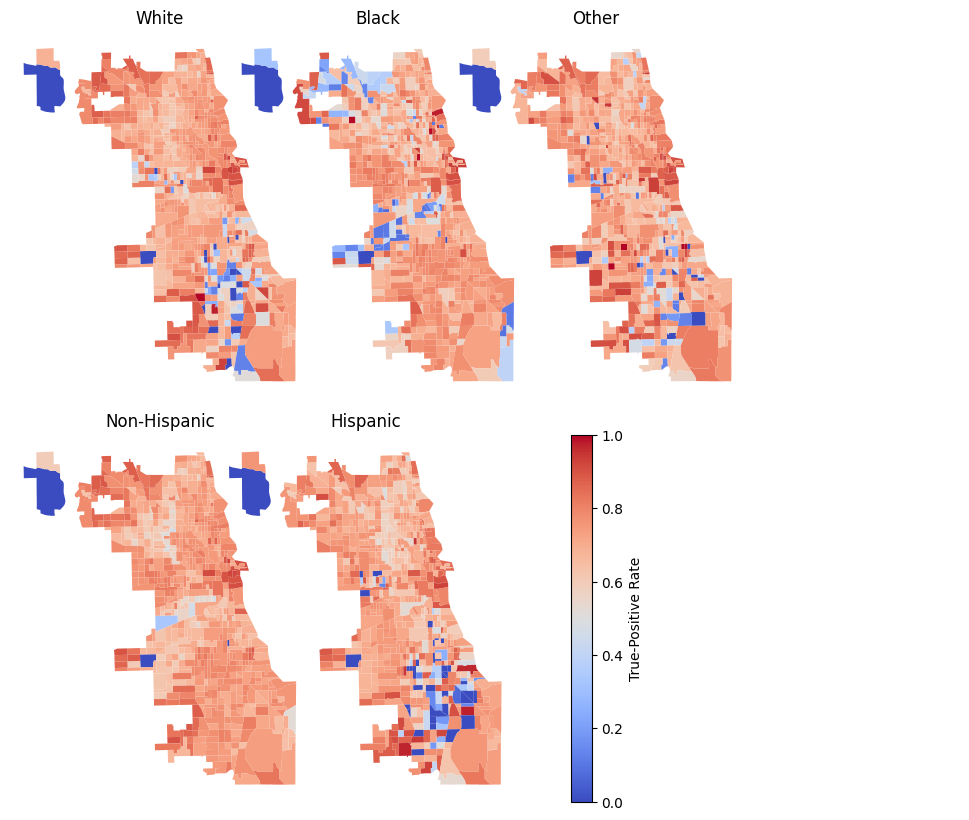

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the columns and titles for the subplots
columns = ['dp_white', 'dp_black', 'dp_other', 'dp_nhisp', 'dp_hisp']
titles = ['White', 'Black', 'Other', 'Non-Hispanic', 'Hispanic']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Create two rows and three columns of subplots

# Create a colorbar axis
divider = make_axes_locatable(ax[1, 1])  # Use the bottom-right subplot for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.05)

for i in range(5):
    r, c = divmod(i, 3)  # Calculate the row and column for each subplot
    gdf_all.plot(column=columns[i], missing_kwds={'color': 'lightgrey'}, cmap='coolwarm', vmin=0, vmax=1, ax=ax[r, c])
    ax[r, c].set_title(titles[i])
    ax[r, c].set_axis_off()
ax[1, 2].set_axis_off()

# Create a single colorbar for all subplots
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('True-Positive Rate')

plt.subplots_adjust(wspace=-0.7, hspace=0.1)  # Adjust the spacing between subplots
plt.savefig('tpr.png', bbox_inches='tight')
plt.savefig('tpr.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

In [24]:
gdf_all2 = gdf_all.merge(gdf_pop[['GEOID_Data', 'total', 'white', 'black', 'race_other', 'hisp', 'nhisp']], on='GEOID_Data', how='left')
gdf_all2['dp_race'] = (gdf_all2['dp_white'] * gdf_all2['white'] + 
                           gdf_all2['dp_black'] * gdf_all2['black'] +
                           gdf_all2['dp_other'] * gdf_all2['race_other']) / (gdf_all2['white'] + gdf_all2['black'] + gdf_all2['race_other'])

print(gdf_all2['dp_race'].var(), gdf_all2['dp_white'].var(), gdf_all2['dp_black'].var(), gdf_all2['dp_other'].var())

gdf_all2['dp_ethnicity'] = (gdf_all2['dp_hisp'] * gdf_all2['hisp'] + 
                           gdf_all2['dp_nhisp'] * gdf_all2['nhisp']) / (gdf_all2['hisp'] + gdf_all2['nhisp'])

print(gdf_all2['dp_ethnicity'].var(), gdf_all2['dp_hisp'].var(), gdf_all2['dp_nhisp'].var())

0.006179671770382744 0.02747819672160926 0.029536674972983165 0.03657440124787195
0.0034302364266820054 0.035695386724390814 0.00846713734495743


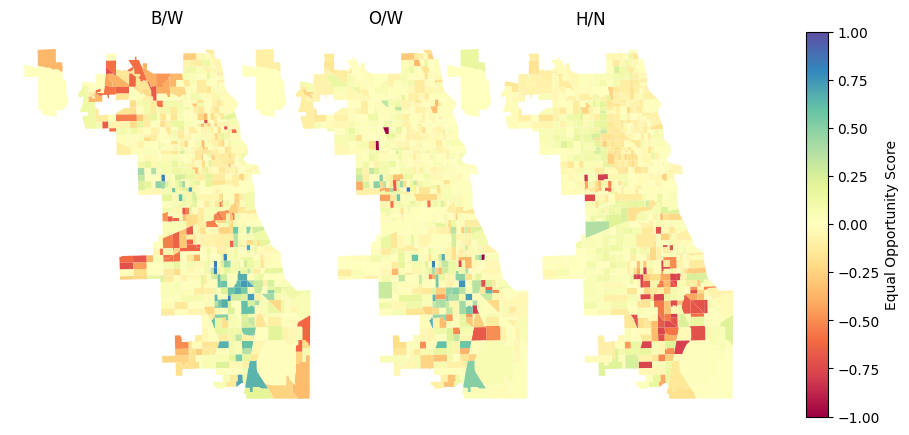

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

gdf_all['b/w'] = gdf_all['dp_black'] - gdf_all['dp_white']
gdf_all['o/w'] = gdf_all['dp_other'] - gdf_all['dp_white']
gdf_all['h/n'] = gdf_all['dp_hisp'] - gdf_all['dp_nhisp']

# Define the columns and titles for the subplots
columns = ['b/w', 'o/w', 'h/n']
titles = ['B/W', 'O/W', 'H/N']

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))  # Create two rows and three columns of subplots

# Create a colorbar axis
divider = make_axes_locatable(ax[2])  # Use the bottom-right subplot for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.05)

for i in range(3):
    gdf_all.plot(column=columns[i], missing_kwds={'color': 'lightgrey'}, cmap='Spectral', vmin=-1, vmax=1, ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()

# Create a single colorbar for all subplots
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Equal Opportunity Score')

plt.subplots_adjust(wspace=-0.7, hspace=0.1)  # Adjust the spacing between subplots
plt.savefig('equal_opp.png', bbox_inches='tight')
plt.savefig('equal_opp.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()